In [1]:
pip install mediapipe opencv-python


Note: you may need to restart the kernel to use updated packages.


In [1]:
import cv2
import numpy as np
import mediapipe as mp

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=2,
    min_detection_confidence=0.7  # Increased for better accuracy
)
mp_drawing = mp.solutions.drawing_utils

def extract_keypoints(image):
    # Resize image if it's too large (optional)
    image = cv2.resize(image, (640, 480)) if image.shape[1] > 640 else image
    
    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)

    keypoints = []

    if results.multi_hand_landmarks:
        # Sort hands by x-coordinate of wrist for consistency (left/right hand order)
        sorted_hands = sorted(results.multi_hand_landmarks, key=lambda hand: hand.landmark[0].x)
        
        for hand_landmarks in sorted_hands:
            for lm in hand_landmarks.landmark:
                keypoints.extend([lm.x, lm.y, lm.z])
        
        # If only one hand detected, pad for second hand
        if len(sorted_hands) == 1:
            keypoints.extend([0] * (21 * 3))
    else:
        # No hands detected — fill both with zeros
        keypoints.extend([0] * (2 * 21 * 3))
    
    return keypoints


In [2]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [3]:
from tqdm import tqdm
import os
import cv2
import numpy as np

DATA_PATH = 'Dataset'
labels = os.listdir(DATA_PATH)  # ['class1', 'class2', ..., 'class48']
label_map = {label: num for num, label in enumerate(labels)}

X = []
y = []

# Wrap outer loop with tqdm for progress tracking
for label in tqdm(labels, desc="Processing Classes"):
    folder_path = os.path.join(DATA_PATH, label)
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        image = cv2.imread(img_path)
        keypoints = extract_keypoints(image)
        X.append(keypoints)
        y.append(label_map[label])

X = np.array(X)
y = np.array(y)


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Dataset'

In [7]:
import pickle

# Save the extracted features
with open('sign_language_features.pkl', 'wb') as f:
    pickle.dump({'X': X, 'y': y, 'labels': labels}, f)

# To load later:
# with open('sign_language_features.pkl', 'rb') as f:
#     data = pickle.load(f)
#     X, y, labels = data['X'], data['y'], data['labels']

In [1]:
# =====================
# 1. Load and Preprocess Dataset
# =====================
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# Load your saved dataset
with open('sign_language_features.pkl', 'rb') as f:
    data = pickle.load(f)
    X, y, labels = data['X'], data['y'], data['labels']

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert labels to one-hot
y = to_categorical(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2]:
# =====================
# 2. Build Optimized Model (Updated for Keras 3)
# =====================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

model = Sequential([
    Dense(256, activation='relu', input_shape=(X.shape[1],), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    Dense(len(labels), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Updated callbacks for Keras 3
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)  # Changed to .keras
]

c:\Users\Mystery_soul\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [3]:
# =====================
# 3. Train and Save Model
# =====================
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=32,
    callbacks=callbacks
)

# For explicit saving (optional)
model.save('final_model.keras')  # Preferred format for Keras 3

Epoch 1/200
290/290 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4151 - loss: 2.1442 - val_accuracy: 0.7306 - val_loss: 1.0725
Epoch 2/200
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6791 - loss: 1.2038 - val_accuracy: 0.7807 - val_loss: 0.8865
Epoch 3/200
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7160 - loss: 1.0762 - val_accuracy: 0.8087 - val_loss: 0.8024
Epoch 4/200
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7390 - loss: 0.9926 - val_accuracy: 0.8148 - val_loss: 0.7665
Epoch 5/200
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7352 - loss: 0.9755 - val_accuracy: 0.8225 - val_loss: 0.7420
Epoch 6/200
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7545 - loss: 0.8901 - val_accuracy: 0.8290 - val_loss: 0.7019
Epoch 7/200
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7738 - loss: 0.8365 - val_accuracy: 0.8092 - val_loss: 0.6937
Epoch 8/200
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7736 - loss: 0.8252 - val_accu

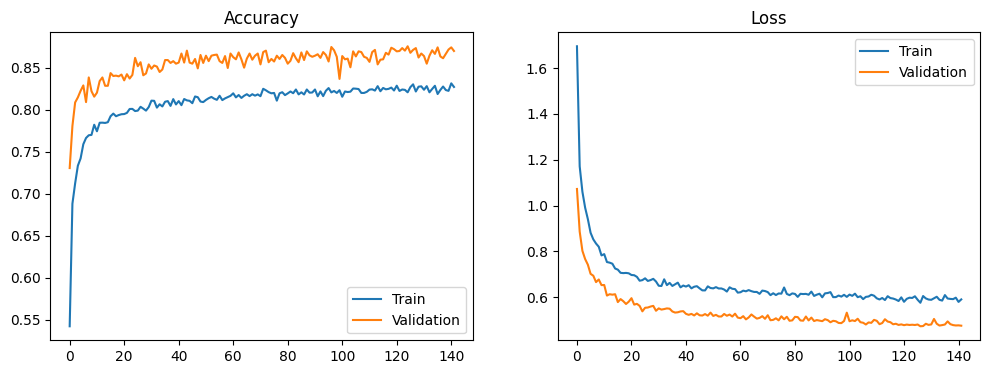

In [4]:
# =====================
# 4. Evaluate Model
# =====================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.show()

In [14]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import pickle

# Fit a new scaler
scaler = StandardScaler()
scaler.fit(X_train)

# Save it for future use
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [2]:
import pickle
from tensorflow.keras.models import load_model
def load_models():
    model = load_model('final_model.keras')
    with open('scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    return model, scaler

model, scaler = load_models()

In [4]:
with open('sign_language_features.pkl', 'rb') as f:
    data = pickle.load(f)
    labels = data['labels']


In [5]:
# =====================
# 5. Real-Time Webcam Prediction (Optimized)
# =====================
import cv2
import mediapipe as mp
import numpy as np
from collections import deque

# Initialize MediaPipe with thread-safe settings
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.7,
    min_tracking_confidence=0.5,
    model_complexity=1  # Balanced accuracy/speed (0=light, 1=balanced, 2=heavy)
)

# Prediction smoothing and state management
pred_history = deque(maxlen=5)  # Stores last 5 predictions
last_valid_pred = None  # Stores last high-confidence prediction

cap = cv2.VideoCapture(0)

# Check if webcam is opened successfully
if not cap.isOpened():
    raise IOError("Cannot open webcam")

# Set desired frame dimensions (improves processing speed)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

try:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame")
            break
        
        # Mirror and resize frame
        frame = cv2.flip(frame, 1)
        frame = cv2.resize(frame, (640, 480))  # Smaller = faster processing
        
        # Convert to RGB
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Process with MediaPipe
        results = hands.process(image_rgb)
        
        if results.multi_hand_landmarks:
            # Extract keypoints
            keypoints = []
            for hand_landmarks in sorted(results.multi_hand_landmarks, 
                                       key=lambda h: h.landmark[0].x):
                for lm in hand_landmarks.landmark:
                    keypoints.extend([lm.x, lm.y, lm.z])
            
            # Pad if only one hand detected
            if len(results.multi_hand_landmarks) == 1:
                keypoints.extend([0] * (21 * 3))
            
            try:
                # Normalize and predict
                keypoints = scaler.transform([keypoints])
                prediction = model.predict(keypoints, verbose=0)
                pred_class = np.argmax(prediction)
                confidence = np.max(prediction)
                
                # Update prediction history
                pred_history.append(pred_class)
                final_pred = max(set(pred_history), key=list(pred_history).count)
                
                # Only update last_valid_pred if confidence is high
                if confidence > 0.8:
                    last_valid_pred = (final_pred, confidence)
                
                # Display either current or last valid prediction
                display_class, display_conf = last_valid_pred if last_valid_pred else (None, 0)
                
                if display_class is not None:
                    cv2.putText(frame, f"{labels[display_class]} ({display_conf:.2f})", 
                                (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
                else:
                    cv2.putText(frame, "Low Confidence", (10, 50), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
                
                # Draw landmarks with different colors for each hand
                colors = [(0,255,0), (0,0,255)]  # Green and red
                for idx, hand_landmarks in enumerate(results.multi_hand_landmarks):
                    mp.solutions.drawing_utils.draw_landmarks(
                        frame, 
                        hand_landmarks, 
                        mp_hands.HAND_CONNECTIONS,
                        landmark_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(
                            color=colors[idx % len(colors)], thickness=2, circle_radius=2),
                        connection_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(
                            color=colors[idx % len(colors)], thickness=2)
                    )
            
            except Exception as e:
                print(f"Prediction error: {e}")
                cv2.putText(frame, "Prediction Error", (10, 50), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
        else:
            cv2.putText(frame, "No Hands Detected", (10, 50), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
        
        # Add FPS counter
        fps = cap.get(cv2.CAP_PROP_FPS)
        cv2.putText(frame, f"FPS: {fps:.1f}", (10, 90), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
        
        cv2.imshow('Sign Language Recognition', frame)
        
        # Exit on 'q' or ESC key
        key = cv2.waitKey(10)
        if key in (ord('q'), 27):  # 27 = ESC
            break

finally:
    cap.release()
    cv2.destroyAllWindows()

Prediction error: X has 189 features, but StandardScaler is expecting 126 features as input.


In [7]:
import pickle

# Save the trained scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)


In [9]:
import pickle

# After fitting your label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)


NameError: name 'label_encoder' is not defined